<h1 style="font-size:200%; background-color:#FFB6C1; color:black; text-align:center; line-height:60px;">
    PATCHMATCH ALGORITHM
</h1>


<h2 style="font-size:100%;  color:black; text-align:left; line-height:30px; font-style:italic;">
    Developed by: Laura Manuela Castañeda Medina - Daniel Felipe Torres Robles
</h2>

<p style="font-size:100%; color:black; text-align:justify; line-height:30px;">
    The PatchMatch algorithm is an efficient random search algorithm for finding approximate nearest neighbor matches between image patches. The algorithm iteratively improves the match of a patch from one image in another image, leveraging the coherence property of natural images. 
    
    
   - The application of the PatchMatch algorithm in this project is only focused on the detection of image manipulation.


In [1]:
# Developped in a conda environment
!conda install numpy matplotlib tqdm scikit-image imageio pillow opencv -y
!pip install opencv-python-headless
!pip install prettytable
!pip install opencv-python

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\ProgramData\anaconda3\envs\jupyter_env

  added / updated specs:
    - imageio
    - matplotlib
    - numpy
    - opencv
    - pillow
    - scikit-image
    - tqdm


The following NEW packages will be INSTALLED:

  eigen              pkgs/main/win-64::eigen-3.3.7-h59b6b97_1 
  ffmpeg             pkgs/main/win-64::ffmpeg-4.2.2-he774522_0 
  gst-plugins-base   pkgs/main/win-64::gst-plugins-base-1.18.5-h9e645db_0 
  gstreamer          pkgs/main/win-64::gstreamer-1.18.5-hd78058f_0 
  hdf5               pkgs/main/win-64::hdf5-1.12.1-h51c971a_3 
  libogg             pkgs/main/win-64::libogg-1.3.5-h2bbff1b_1 
  libprotobuf        pkgs/main/win-64::libprotobuf-3.20.3-h23ce68f_0 
  libvorbis          pkgs/main/win-64::libvorbis-1.3.7-he774522_0 
  opencv             pkgs/main/win-64::opencv-4.6.0-py39ha36de5b_5 

The following packages will be UPDATED:

  openssl                                 3.0.11-h2bbff



==> WARNING: A newer version of conda exists. <==
  current version: 23.9.0
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



EnvironmentNotWritableError: The current user does not have write permissions to the target environment.
  environment location: C:\ProgramData\anaconda3\envs\jupyter_env




Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Libraries
import pandas as pd
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec

from scipy.ndimage import rotate
from prettytable import PrettyTable
from skimage import io
from skimage.io import imread
from tqdm.notebook import tqdm
from imageio.v2 import imread
from PIL import Image
from prettytable import PrettyTable
from matplotlib.animation import FuncAnimation

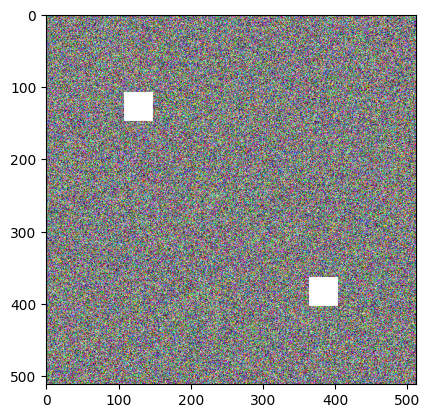

In [3]:
'''
This section of code provides a simple method for generating 
test images to evaluate some features of the algorithm.
'''
%matplotlib inline

# Image settings: 
width, height, im_size = 512, 512, 512
img = Image.new("RGB", (width, height))
pixels = img.load()

# Random RGB color
def random_color():
    return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

for i in range(width):
    for j in range(height):
        pixels[i, j] = random_color()

# Draw a 20x20 white squares
def draw_white_square(start_x, start_y, size=20):
    for x in range(start_x, start_x + size):
        for y in range(start_y, start_y + size):
            pixels[x, y] = (255, 255, 255)

# Positions for the squares
square_size = 40
square1_x, square1_y = (width // 4) - (square_size // 2), (height // 4) - (square_size // 2)
square2_x, square2_y = (3 * width // 4) - (square_size // 2), (3 * height // 4) - (square_size // 2)

draw_white_square(square1_x, square1_y, square_size)
draw_white_square(square2_x, square2_y, square_size)

# Save the image
img.save("512x512_squares.png")

# Numpy array for plotting
np_img = np.array(img)

# Plot
plt.imshow(np_img)
plt.axis('on')  
plt.show()

<h2 style="font-size:150%;  color:black; background-color:#FFB6C1; text-align:left; line-height:30px; font-style:italic;">
    Visualization in HSV Space.
</h2>

In [4]:
def visualize_as_image(nnf, ax=None):
    
    """
    Visualize the NNF as an image, using angle to represent direction
    and magnitude to represent color intensity.
    """
    
    # Convert NNF to angles and magnitude
    angles = np.arctan2(nnf[:,:,1], nnf[:,:,0])
    magnitude = np.sqrt(nnf[:,:,0]**2 + nnf[:,:,1]**2)

    # Normalize angle to [0, 1]
    normalized_angles = (angles + np.pi) / (2 * np.pi)

    # Normalize magnitude 
    normalized_magnitude = np.clip(magnitude / (patch_size**2), 0, 1) 

    # HSV image where angle is hue, magnitude is value, and saturation is 1
    hsv_image = np.stack([normalized_angles, np.ones_like(normalized_angles), normalized_magnitude], axis=-1)

    # Convert from HSV to RGB for visualization
    rgb_image = colors.hsv_to_rgb(hsv_image)

    if ax:
        ax.imshow(rgb_image)
    else:
        plt.imshow(rgb_image)
        plt.show()


 ### Function Purpose
 The `visualize_as_image` function is designed to visualize a Nearest Neighbor Field (NNF),
 which is a data structure commonly used in image processing. The NNF consists of 2D vectors 
 at each pixel, representing offsets to the nearest matching pixel in another image or patch. 
 This visualization represents these offsets in a visual format.
 
 ### Parameters
 
 - `nnf`: The input Nearest Neighbor Field, a two-channel image with each pixel containing 
   a 2D vector (x and y offsets).
 
 ### Process
 
 1. **Conversion to Angles and Magnitude:**
    - Calculates the angle (using `arctan2`) and magnitude (Euclidean distance) of each vector.
    - Angle represents the direction, and magnitude represents the distance of the nearest neighbor.
 
 
 2. **Normalization:**
    - Angles are normalized to [0, 1] by adjusting from [-π, π] to [0, 2π], then scaling down.
    - Magnitudes are normalized relative to the patch size and clipped to [0, 1].

 3. **Creating an HSV Image:**
     - Constructs an HSV image using normalized angles (hue), fixed saturation (1), and magnitudes   (value).
     - Maps direction to color (hue) and distance to brightness (value).
  
  4. **Conversion to RGB and Display:**
     - Converts the HSV image to RGB for display.
     - Displays the image using `imshow` on the given axis or in a new window.


<h2 style="font-size:150%;  color:black; background-color:#FFB6C1; text-align:left; line-height:30px; font-style:italic;">
    FIRST STAGE (random initialization)
</h2>

<p style="font-size:100%; color:black; text-align:justify; line-height:30px; font-style:italic;">
Initialize random displacements as the starting point for the algorithm.

In [10]:
def initialize_displacements_for_patches(imageA, imageB):
    
    height, width, _ = imageA.shape
    nnf = np.zeros((height, width, 2))
    
    for x in tqdm(range(0, width, patch_size)):
        for y in range(0, height, patch_size):
            
            random_x = np.random.randint(0, width)
            random_y = np.random.randint(0, height)
            
            # Save each displacement in NNF Space Matrix
            nnf[x : x+patch_size, y : y+patch_size] = [random_x - x, random_y - y]

    return nnf


  ### Function Purpose
The `initialize_displacements_for_patches` function initializes the Nearest Neighbor Field (NNF) 
for two given images (imageA and imageB). This initialization is a key step in the pathmatch   algorithm like, where each pixel's nearest neighbor information is crucial.
  
  ### Parameters
  - `imageA`: The source image.
  - `imageB`: The target image.
  
  ### Process
  1. **Initialization:**
     - Extracts the dimensions (height and width) of `imageA`.
     - Initializes an NNF matrix of the same size as `imageA`, with each element being a 2D vector.
  
  2. **Generating Random Displacements:**
     - Iterates over the image in steps of `patch_size`.
     - For each patch, a random displacement vector is generated.
       - This vector points from the current patch in `imageA` to a random location in `imageB`.
       - The randomness here serves as an initial guess for the NNF.
  
  3. **Populating the NNF:**
     - For each patch, the computed displacement (difference between random coordinates and 
       current patch's coordinates) is stored in the NNF matrix.
  
  ### Return
  - Returns the initialized NNF matrix, where each entry represents the initial offset from 
    a patch in `imageA` to a random location in `imageB`.
  

 


  0%|          | 0/128 [00:00<?, ?it/s]

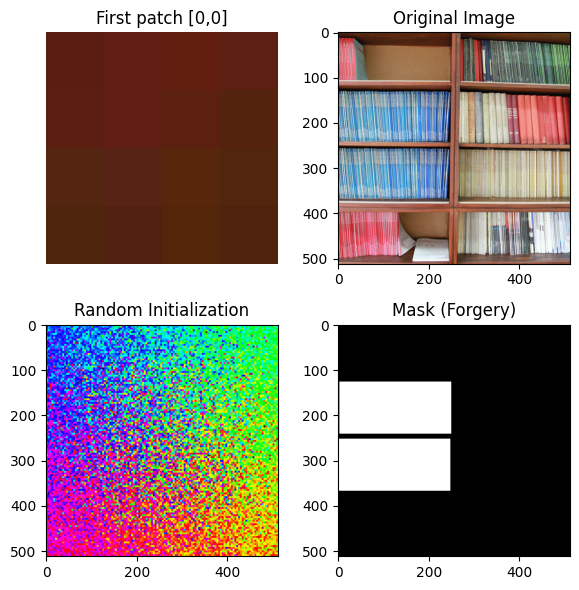

In [13]:
# Size of the patch (High value increases accruracy and computational cost)
patch_size = 4

imageA = imread('Support Project IMA201/Libros_512x512.png')
imageB = imageA.copy()

mask_forgery = imread('Support Project IMA201/Libros_mask_512x512.png')

# Initialize displacements for PatchMatch 
nnf_patchmatch = initialize_displacements_for_patches(imageA, imageB)

# Initialize correspondance mask 
mask_corr = nnf_patchmatch - nnf_patchmatch

# 2x2 figure to display the results and patches
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

x0_image, y0_image = 0, 0  

img_array = np.array(imageA)

# Visualization of the first patch  
first_patch = img_array[y0_image : y0_image + patch_size, x0_image : x0_image + patch_size] 

axes[0, 0].imshow(first_patch)
axes[0, 0].set_title('First patch [0,0]')
axes[0, 0].axis('off')

axes[0, 1].imshow(img_array)
axes[0, 1].set_title('Original Image')
axes[0, 1].axis('on')

visualize_as_image(nnf_patchmatch, ax=axes[1, 0])
axes[1, 0].set_title('Random Initialization')

axes[1, 1].imshow(mask_forgery)
axes[1, 1].set_title('Mask (Forgery)')

plt.tight_layout()
plt.show()

<h2 style="font-size:150%;  color:black; background-color:#FFB6C1; text-align:left; line-height:30px; font-style:italic;">
    SECOND STAGE (propagation)
</h2>
<p style="font-size:100%; color:black; text-align:justify; line-height:30px; font-style:italic;">
Searches in the neighboring directions (up, down, left, and right) to find a more accurate correspondence.


In [9]:
def compute_distance(imageA, imageB, x_0, y_0, x_1, y_1):
    '''
    In this instance, we employ a quadratic distance measure 
    to approximate an improved correspondence.
    '''
    #print("Patch A desde ", x_0, y_0, "hasta", x_0 + patch_size, y_0 + patch_size)
    #print("Patch B desde ", x_1, y_1, "hasta", (x_1 + patch_size) , (y_1 + patch_size))
  
    patchA = imageA[x_0 : (x_0 + patch_size) , y_0 : (y_0 + patch_size) ]
    patchB = imageB[x_1 : (x_1 + patch_size) , y_1 : (y_1 + patch_size) ]
        
    if ( patchA.shape == patchB.shape ):    
        cal_distance = np.sum( (patchA - patchB)**2 ) // ( patch_size**2 )
        
    #print("Patch A: \n", patchA)
    #print("Patch B: \n", patchB)
    #print("--")
    
    else :
        cal_distance = 10000
    
    return cal_distance

  ### Function Purpose
  The `compute_distance` function calculates the quadratic distance between corresponding 
  patches in two images, `imageA` and `imageB`. This distance measure is used to evaluate 
  how similar or different two patches are.
  
  ### Parameters
  - `imageA`: The first image.
  - `imageB`: The second image.
  - `x_0`, `y_0`: Coordinates of the top-left corner of the patch in `imageA`.
  - `x_1`, `y_1`: Coordinates of the top-left corner of the patch in `imageB`.
  
  ### Process
  1. **Extracting Patches:**
     - Extracts patches from `imageA` and `imageB` based on provided coordinates and `patch_size`.
  
  2. **Computing Quadratic Distance:**
     - If the shapes of the two patches are equal, the function calculates the quadratic (squared) 
       difference between them. This is done by subtracting corresponding pixels in the patches, 
       squaring these differences, and summing them all.
     - The sum is then normalized by dividing it by the squared `patch_size`.
     - If the patch shapes don't match, it assigns a high distance value $d=10000$ indicating no match.
  
  ### Return
  - Returns the calculated distance, a measure of similarity between the two patches. 
    A lower distance indicates a closer match.
 

In [8]:
def propagate(imageA, imageB, nnf):
    '''
    We iterate over each pixel to find a smaller distance value, 
    which is used to update the Nearest Neighbor Field (NNF).
    '''
    height, width, _ = imageA.shape
    nnf_updated = nnf.copy()
    
    for x in range(0, width, patch_size):
        for y in range(0 , height, patch_size):

            new_distance = [10000, 10000, 10000, 10000]
            dx, dy = nnf[x,y]
            dx = int(dx)
            dy = int(dy)
            #print('POSITION:', x, y)
            #print('Current nnf:', nnf[x,y])
            #print('dx dy:', dx, dy)
            
            current_distance = compute_distance(imageA, imageB, x, y, x + dx, y + dy)
            #print ('Current distance:', current_distance)
                
            if((x+dx) + 1) < width: 
                new_distance[0] = compute_distance(imageA, imageB, x, y, x+dx + 1, y+dy)
            
            #print("Posiciones a Comparar 1 : ", patch_size*x, patch_size*y, patch_size*(x+dx - 1), patch_size*(y+dy))
            #print("IF : ", (patch_size*(x+dx - 1)), "MAYOR O IGUAL A 0" )
            
            if((x+dx) - 1) >= 0:                  
                new_distance[1] = compute_distance(imageA, imageB, x, y, x+dx - 1, y+dy)
           
            #print("Posiciones a Comparar 2 : ", patch_size*x, patch_size*y, patch_size*(x+dx), patch_size*(y+dy + 1))
            #print("IF : ", (patch_size*(y+dy + 1)), "MENOR A ", height / patch_size)
            
            if((y+dy) + 1) < height: 
                new_distance[2] = compute_distance(imageA, imageB, x, y, x+dx, y+dy + 1)
            
            #print("Posiciones a Comparar 3 : ", patch_size*x, patch_size*y, patch_size*(x+dx), patch_size*(y+dy - 1))
            #print("IF : ", (patch_size*(y+dy - 1)), "MAYOR O IGUAL A 0" ) 
            
            if((y+dy) - 1) >= 0:                  
                new_distance[3] = compute_distance(imageA, imageB, x, y, x+dx, y+dy - 1)
            
            #print("New distance: ", new_distance)
            
            minimo = np.min(new_distance)
            indice = np.argmin(new_distance)
            prop_offset = [[1, 0], [-1, 0], [0, 1], [0, -1]][indice]
            
            # NFF update            
            if (minimo == 0) and (dx + prop_offset[0] != 0) and (dy + prop_offset[1] != 0): 
                print("minimo: ", minimo, "dx: ", dx, "dy: ", dy)
                mask_corr[x : x+patch_size, y : y+patch_size] = [256, 256]
            
            if (current_distance >= minimo): 
                nnf_updated[x : x+patch_size, y : y+patch_size] = [dx + prop_offset[0], dy + prop_offset[1]]
                
            else:  nnf_updated[x : x+patch_size, y : y+patch_size] = nnf[x : x+patch_size, y : y+patch_size]

            #print("indice: ", indice)
            
            #print("New distance_min: ", minimo)
            #print("nnf_updated: ", nnf_updated[x,y])
            #print("--------------------------------------------")
            
    return nnf_updated

 ### Function Purpose
 The `propagate` function is a core component in the PatchMatch algorithm. Its purpose is to iteratively update the NNF by finding smaller distance values between patches in two images (`imageA` and `imageB`). This process helps in refining the NNF to more accurately represent the nearest neighbor relationships between the patches of the two images.
 
 ### Parameters
 - `imageA`: The first image.
 - `imageB`: The second image.
 - `nnf`: The current Nearest Neighbor Field matrix.
 
 ### Process
 1. **Initialization:**
    - Extracts the dimensions of `imageA`.
    - Copies the existing NNF to create an updated NNF matrix.
 
 2. **Iterating Over Patches:**
    - Iterates over the image in steps of `patch_size`.
    - For each patch, it calculates the current distance and potential new distances 
      by shifting the corresponding patch in `imageB`.
 
 3. **Evaluating Neighboring Patches:**
    - For each patch in `imageA`, the function checks neighboring patches in `imageB` 
      (left, right, up, down) to see if they provide a smaller distance.
 
 4. **Updating the NNF:**
    - If a neighboring patch provides a smaller distance, the NNF is updated with the new offset.
    - The update is based on the comparison of current and new distances.
 
 ### Return
 - Returns the updated NNF matrix, which reflects the improved nearest neighbor 
   relationships after the propagation step.

minimo:  0 dx:  126 dy:  -1


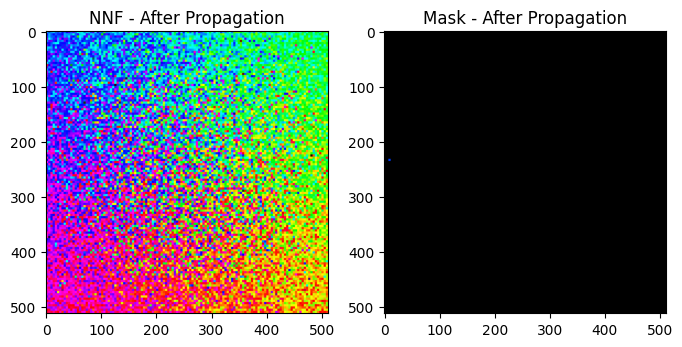

In [14]:
nnf_patchmatch_updated = propagate(imageA, imageB, nnf_patchmatch)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

visualize_as_image(nnf_patchmatch_updated, ax=axes[0])
axes[0].set_title('NNF - After Propagation')

visualize_as_image(mask_corr, ax=axes[1])
axes[1].set_title('Mask - After Propagation')

#print(nnf_patchmatch_updated)

plt.show()

<h2 style="font-size:150%;  color:black; background-color:#FFB6C1; text-align:left; line-height:30px; font-style:italic;">
    THIRD STAGE (Random search)
</h2>
<p style="font-size:100%; color:black; text-align:justify; line-height:30px; font-style:italic;">
Efficiently searches for correspondences within a predefined circular area, characterized by a radius R, using randomized values.

In [7]:
def random_search(imageA, imageB, nnf, x, y, search_radius):
    '''
    Similar to the previous stage, we iterate over each pixel to identify a more 
    accurate correspondence within the circles and update the Nearest Neighbor Field (NNF).
    '''  
    height, width, _ = imageA.shape
    nnf_updated = nnf.copy()
    
    dx, dy = nnf[x, y]
    dx = int(dx)
    dy = int(dy)
    #print("dx dy : ", dx, dy)
    
    current_distance = compute_distance(imageA, imageB, x, y, x+dx, y+dy)
    #print("Current nnf", nnf[x, y])
    #print("Current distance: ", current_distance)
    
    best_dx, best_dy = dx, dy
    best_distance = current_distance

    for _ in range(search_radius):
        
        random_dx = np.random.randint(-search_radius, search_radius) 
        random_dy = np.random.randint(-search_radius, search_radius) 
        #print("Random dx dy : ", random_dx, random_dy)
        
        new_distance = 10000;
        
        if( (0 <= x+random_dx < width-1) and (0 <= y+random_dy < height-1) ):
            new_distance = compute_distance(imageA, imageB, x, y, x + dx + random_dx, y + dy + random_dy)
            #print("Posiciones a Comparar : ", x, y, x+random_dx, y+random_dy)
        
        #print("New distance: ", new_distance)
        if new_distance <= best_distance:
            best_dx, best_dy = dx + random_dx, dy + random_dy
            best_distance = new_distance
            
    #print("Best_distance: ", best_distance)
    #print("---------------------")
    
    # NFF update
    if (new_distance == 0) and (dx + random_dx != 0) and (dy + random_dy != 0): 
        mask_corr[x : x+patch_size, y : y+patch_size] = [512, 512]
        print("new_distance: ", new_distance, "dx + random_dx: ", dx + random_dx, "dy + random_dy: ", dy + random_dy)
        
    if (current_distance >= best_distance):
        nnf_updated[x : x+patch_size, y : y+patch_size] = [best_dx, best_dy]
    else:  
        nnf_updated[x : x+patch_size, y : y+patch_size] = nnf[x : x+patch_size, y : y+patch_size]
    
    return nnf_updated



 ## Function Purpose
The `random_search` function is another key component in the Patchmatch algorithm utiling Nearest Neighbor Fields (NNFs). This function aims to enhance the accuracy of the NNF by exploring a broader search space avoiding local convergence. It iteratively tests random displacements within a specied radius to find a more accurate correspondence between patches in two images (`imageA` and `imageB`).
 
 ### Parameters
 - `imageA`: The first image.
 - `imageB`: The second image.
 - `nnf`: The current Nearest Neighbor Field matrix.
 - `x`, `y`: Coordinates of the current patch in `imageA`.
 - `search_radius`: The radius within which random search is performed.
 
 ### Process
 1. **Initialization:**
    - Extracts the dimensions of `imageA`.
    - Copies the existing NNF to create an updated NNF matrix.

 2. **Performing Random Search:**
    - Retrieves the current best displacement (dx, dy) from the NNF.
    - For each iteration within the `search_radius`, generates random displacements.
 
 3. **Evaluating Random Displacements:**
    - Calculates the distance for the patch in `imageA` and a randomly displaced patch in `imageB`.
    - If the new distance is better (smaller) than the current best, updates the best displacement.
 
 4. **Updating the NNF:**
    - If a better displacement is found, updates the NNF with the new displacement.
 
 ### Return
 - Returns the updated NNF matrix, reflecting potentially more accurate correspondences 
   found during the random search.



In [6]:
def apply_random_search(imageA, imageB, nnf, search_function):
    height, width, _ = imageA.shape

    for x in tqdm(range(0, width, patch_size)):
        for y in range( 0, height, patch_size):
            #print(f"Position: ({x}, {y})")
            nnf = search_function(imageA, imageB, nnf, x, y, height)
            
    return nnf

  0%|          | 0/128 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


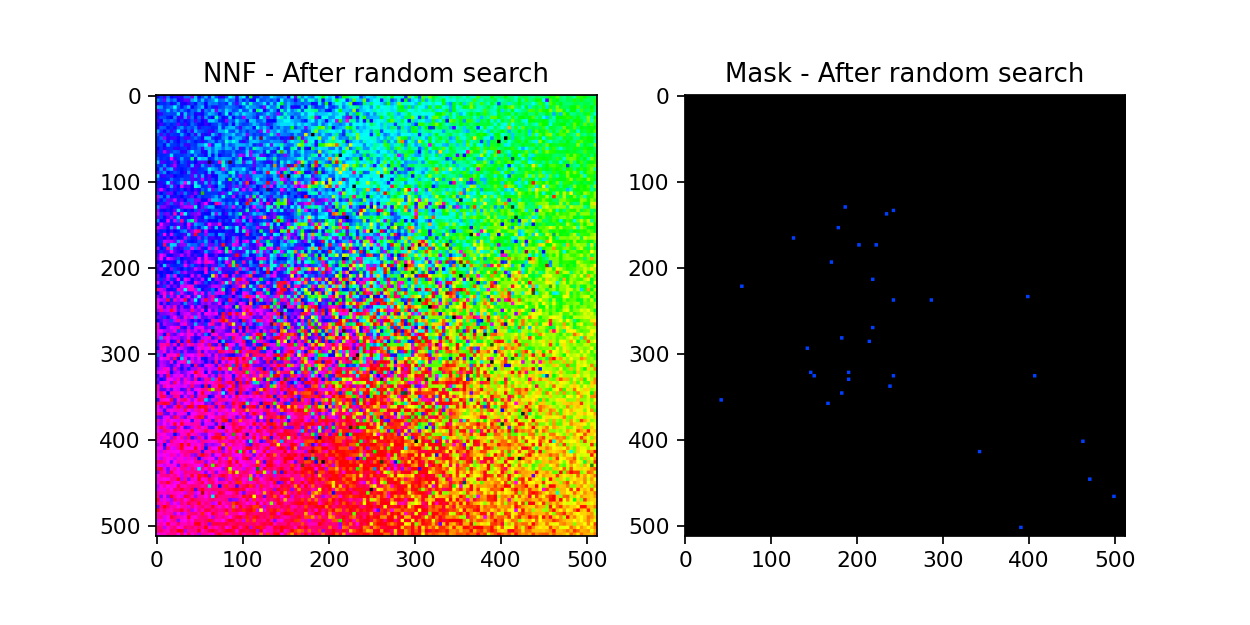

In [33]:
nnf_patchmatch_after_search = apply_random_search(imageA, imageB, nnf_patchmatch_updated, random_search)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

visualize_as_image(nnf_patchmatch_after_search, ax=axes[0])
axes[0].set_title('NNF - After random search')

visualize_as_image(mask_corr, ax=axes[1])
axes[1].set_title('Mask - After random search')

#print(nnf_patchmatch_updated)
plt.show()

<h2 style="font-size:150%;  color:black; background-color:#FFB6C1; text-align:left; line-height:30px; font-style:italic;">
    PATCHMATCH (Iterative process)
</h2>

<IPython.core.display.Javascript object>


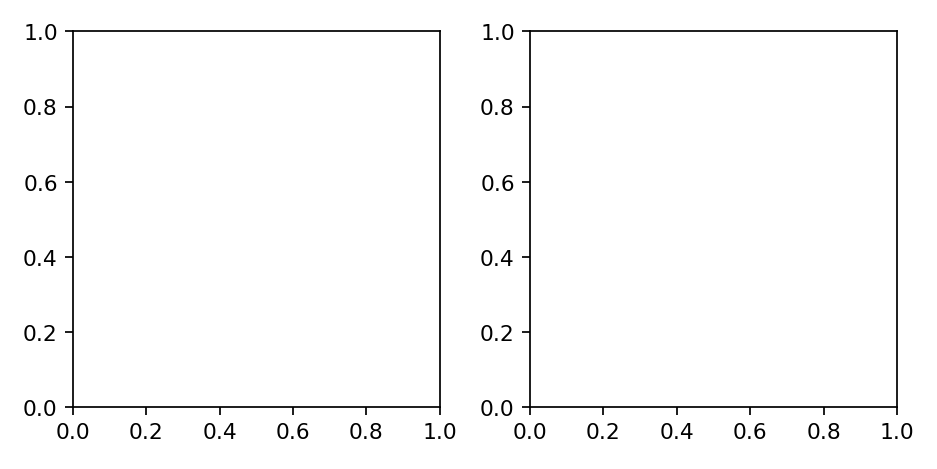

  0%|          | 0/128 [00:00<?, ?it/s]

In [14]:
%matplotlib notebook  

# Size of the patch (High value increases accruracy and computational cost)
patch_size = 4

imageA = imread('Support Project IMA201/Libros_512x512.png')
imageB = imageA.copy()

num_iterations = 25

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))  # Dos ejes en una fila

nnf_patchmatch_start = initialize_displacements_for_patches(imageA, imageB)  # Inicializamos de nuevo
mask_corr = nnf_patchmatch_start - nnf_patchmatch_start

def update(frame):
    global nnf_patchmatch_start
    
    nnf_patchmatch_prop = propagate(imageA, imageB, nnf_patchmatch_start)
    ax1.clear()
    visualize_as_image(mask_corr, ax=ax1)
    ax1.set_title('Propagación - Iteración ' + str(frame))
    
    nnf_patchmatch_after_search = apply_random_search(imageA, imageB, nnf_patchmatch_prop, random_search)
    ax2.clear()
    visualize_as_image(nnf_patchmatch_after_search, ax=ax2)
    ax2.set_title('Búsqueda Aleatoria - Iteración ' + str(frame))
    
    nnf_patchmatch_start = nnf_patchmatch_after_search

ani = FuncAnimation(fig, update, frames=range(num_iterations), repeat=False)

plt.tight_layout()
plt.show()


 ### Script Purpose
This script visualizes the iterative process of refining a Nearest Neighbor Field (NNF) for two images, `imageA` and `imageB`, using the PatchMatch algorithm. It employs the three stages presented previously. The visualization is done using an animation to observe the evolution of the NNF over a set number of iterations.
 
 ### Visualization
The animation sequentially shows the impact of the propagation and random search steps on the NNF,
 with each iteration improving the field's accuracy in matching patches between `imageA` and `imageB`. 

The `mask_corr` matrix holds the most crucial outcome of the process. This matrix identifies patches that achieve the best correspondence, specifically where the distance approaches zero, in locations different from their initial positions. This indicates that in these areas, a segment of the image has been effectively replicated, highlighting regions of duplicate content. In essence, the `mask_corr` matrix serves as a key indicator of successfully matched and duplicated sectors within the images, providing valuable insights into the areas of high similarity or repetition."



C:\Users\danie\AppData\Local\Temp\ipykernel_3404\1646974953.py:5: RuntimeWarning: invalid value encountered in divide
  mask_gray = (mask_gray / np.max(mask_gray)) * 255
C:\Users\danie\AppData\Local\Temp\ipykernel_3404\1646974953.py:8: RuntimeWarning: invalid value encountered in cast
  _, mask_thresh = cv2.threshold(mask_gray.astype(np.uint8), 127, 255, cv2.THRESH_BINARY_INV)


<IPython.core.display.Javascript object>


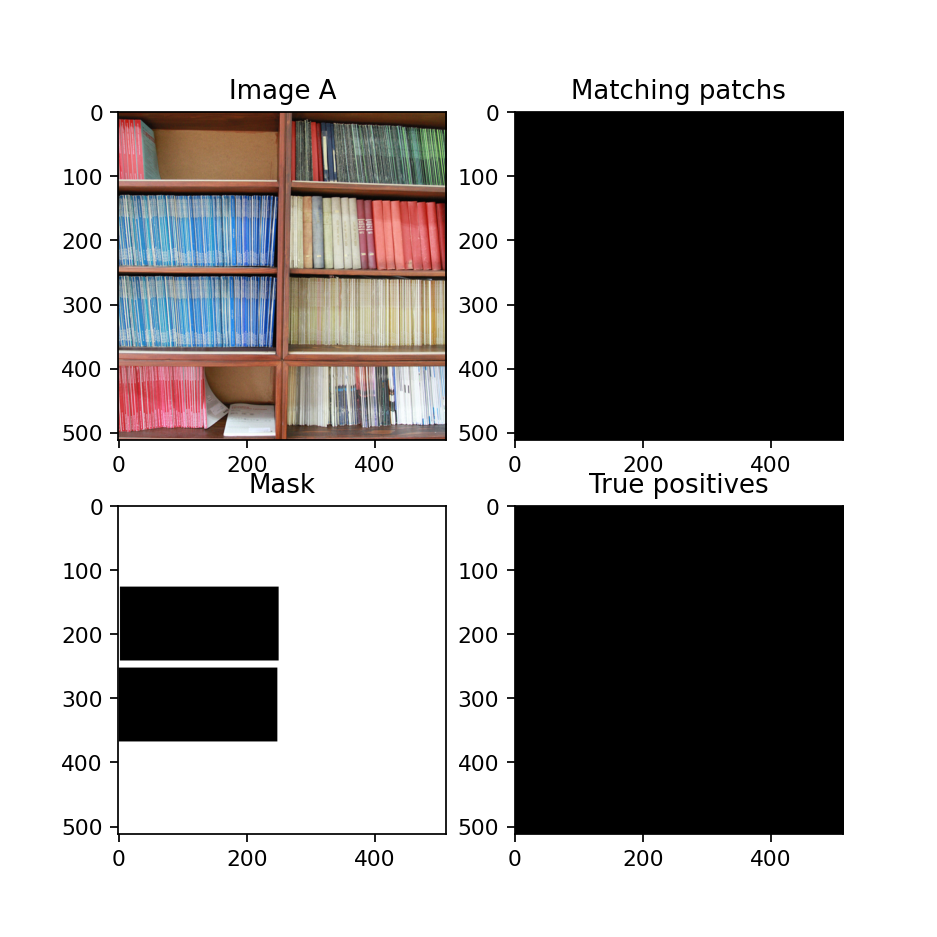

In [15]:
imageA_mask = imread('Support Project IMA201/Libros_mask_512x512.png')

# Mask grayscaled for display
mask_gray = np.sqrt(mask_corr[:,:,0]**2 + mask_corr[:,:,1]**2)
mask_gray = (mask_gray / np.max(mask_gray)) * 255  

# Threshold the images and the mask
_, mask_thresh = cv2.threshold(mask_gray.astype(np.uint8), 127, 255, cv2.THRESH_BINARY_INV)
_, imageA_mask_thresh = cv2.threshold(imageA_mask, 127, 255, cv2.THRESH_BINARY)

# Negative value to invert the mask of the image (Comment if not)
imageA_mask_thresh=~imageA_mask_thresh

results = ~(imageA_mask_thresh[:, :, 0] | mask_thresh)

fig, axs = plt.subplots(2, 2, figsize=(6, 6))

axs[0, 0].imshow(imageA, cmap='gray')
axs[0, 0].set_title('Image A')
axs[0, 0].axis('on')

axs[0, 1].imshow(mask_thresh, cmap='gray')
axs[0, 1].set_title('Matching patchs')
axs[0, 1].axis('on')

axs[1, 0].imshow(imageA_mask_thresh, cmap='gray')
axs[1, 0].set_title('Mask')
axs[1, 0].axis('on')

axs[1, 1].imshow(results, cmap='gray')
axs[1, 1].set_title('True positives')
axs[1, 1].axis('on')

plt.show()

This image is our starting point for the PatchMatch algorithm (Top-left). It's a photograph of a bookshelf with a variety of books. The diverse patterns and colors on the book spines make it an interesting subject for identifying patch correspondences.

Here we see the final results from an iteration of the algorithm (Top-right). The scatter plot reveals where the algorithm has found similar patches. The clustering of points suggests that certain features or patterns on the bookshelf have been matched with other regions, possibly indicating texture or pattern repetition. However, there are some outlier points in the bottom right corner, seemingly away from any major cluster. These points do not correspond to any apparent duplicate area, which could suggest that the patchsize is not the best for this kind of image.

The true positives shown here are the points that fall within the masked areas (Bottom-right), suggesting that these matches have been validated against the mask criteria (Bottom-left image). Essentially, these are the points where the PatchMatch algorithm found correspondences that are also within the regions we're interested in. It's important to note that true positives are not just any match but are those specifically aligned with the area we've defined as relevant, which in our case is the bookshelf area highlighted by the mask.

As a students, we consider these findings quite insightful. The results show that PatchMatch can discern and isolate features within a complex image. Still, it's not without potential challenges. The outlier matches might require us to refine the algorithm or preprocessing steps further. The precision in the 'True Positives' affirms that the algorithm would be effective when constrained by the mask, which is crucial for tasks such as focused inpainting or feature extraction within designated areas.

 ## Script Purpose
This script segment is designed to process and visualize the results of the implemented algorithm, 
specifically focusing on identifying true positive matches between the mask of the area duplicated and the mask of the patches with the best correspondance. This is the most valuable identifier that we can obtain in order to make conclutions.


In [19]:
im_size, _, _ = imageA.shape
num_patches = (im_size**2) / (patch_size**2)
total_correspondances = num_patches - np.sum(mask_thresh/255) / patch_size**2
true_positives = np.sum(results/255) / patch_size**2
accuracy = true_positives / total_correspondances * 100
accuracy = round(accuracy, 1)

table = PrettyTable()
table.field_names = ["Metric", "Value"]
table.add_row(["Total Correspondences", total_correspondances])
table.add_row(["True Positives", true_positives])
table.add_row(["Accuracy", accuracy])

print(table)

+-----------------------+-------+
|         Metric        | Value |
+-----------------------+-------+
| Total Correspondences |  1.0  |
|     True Positives    |  1.0  |
|        Accuracy       | 100.0 |
+-----------------------+-------+


<h2 style="font-size:150%;  color:black; background-color:#FFB6C1; text-align:left; line-height:30px; font-style:italic;">
    OTHER RESULTS
</h2>

We perform 100 iterations of the PatchMatch algorithm on lower-resolution images, which gave us more results faster. This approach struck a balance between getting the data quickly and still having enough detail to understand how well the algorithm works on different images.

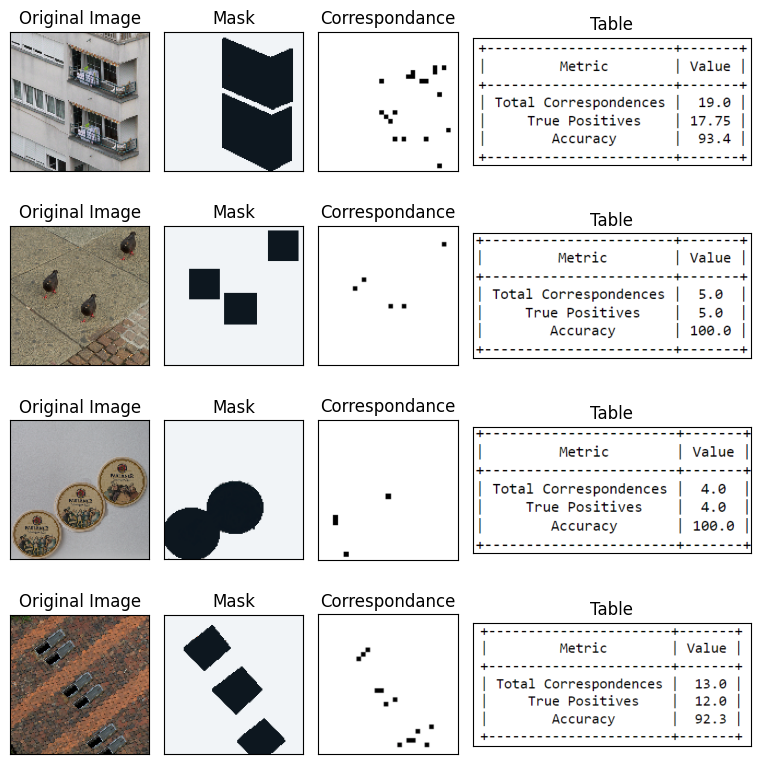

In [25]:
fig = plt.figure(figsize=(8, 8))

# Load your images and masks
imageA, imageB, imageC, imageD = imread('Support Project IMA201/Ventanas_128x128.png'), imread('Support Project IMA201/Palomas_128x128.png'), imread('Support Project IMA201/Portavasos_128x128.png'), imread('Support Project IMA201/Tejas_128x128.png')
maskA, maskB, maskC, maskD = imread('Support Project IMA201/Ventanas_mask.png'), imread('Support Project IMA201/Palomas_mask.png'), imread('Support Project IMA201/Portavasos_mask.png'), imread('Support Project IMA201/Tejas_mask.png')
corrA, corrB, corrC, corrD = imread('Support Project IMA201/Corr_ventanas.png'), imread('Support Project IMA201/Corr_palomas.png'), imread('Support Project IMA201/Corr_portavasos.png'), imread('Support Project IMA201/Corr_tejas.png')
tableA, tableB, tableC, tableD = imread('Support Project IMA201/Tables_ventana.png'), imread('Support Project IMA201/Tables_palomas.png'), imread('Support Project IMA201/Tables_portavasos.png'), imread('Support Project IMA201/Tables_tejas.png')

gs = gridspec.GridSpec(4, 5, width_ratios=[1, 1, 1, 2, 0.1])  

titles = ['Original Image', 'Mask', 'Correspondance', 'Table']

for i in range(4):
    for j in range(4):
        ax = fig.add_subplot(gs[i, j])
        ax.imshow(eval(f'image{chr(65+i)}' if j == 0 else f'{["mask", "corr", "table"][j-1]}{chr(65+i)}'), cmap='gray')
        ax.set_title(titles[j])
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

The results presented here underscore the proficiency of the PatchMatch algorithm in processing images under varying conditions with high precision. By implementing a selective 4x4 pixel mask, we optimized for accuracy, favoring the quality of matches over their quantity. 

This strategic choice enhances the identification of true positives, which is crucial in detecting potential forgeries within the image. It suggests a meticulous and effective approach, where ensuring the reliability of match identification takes precedence.

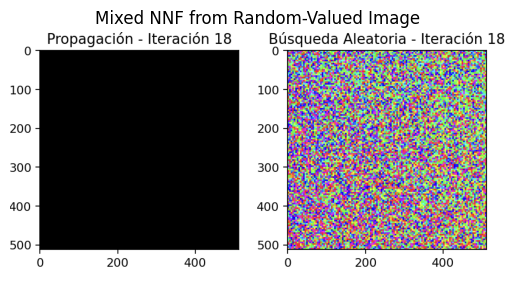

In [26]:
mixed_map = imread('Support Project IMA201/NoCorrespondance.png')
plt.imshow(mixed_map)
plt.title('Mixed NNF from Random-Valued Image')
plt.axis('off') 
plt.show()

Another interesting result was obtained applying the PatchMatch algorithm to an image with random pixel values, where each pixel was a distinct color. The resulting map displayed a totally mixed Nearest Neighbor Field (NNF), indicating that the patches continuously shifted throughout the image in search of correspondences. This behavior reflects the algorithm's exhaustive search for matching patches in an environment where no two pixels are alike, highlighting the challenges faced when attempting to find patterns in highly random or noisy data.

<h2 style="font-size:150%;  color:black; background-color:#FFB6C1; text-align:left; line-height:30px; font-style:italic;">
    MAIN PROBLEMS AND LIMITATIONS
</h2>

### Computational Cost:

- Algorithms like PatchMatch are computationally intensive, especially for high-resolution images or large patch sizes. The iterative nature of processes like propagation and random search adds to the computational burden.

- Distance computation for each patch, particularly using quadratic measures, can be costly in terms of processing time.

### Image Borders:

- Managing patches near the borders of the images is challenging. When a patch overlaps the image boundary, it either needs special handling (like padding) or the algorithm must be adjusted to avoid such overlaps.

- This issue becomes more pronounced with larger patch sizes, where the likelihood of a patch exceeding the image boundary increases.

### Patch Size Considerations:

- Choosing an appropriate patch size is critical. Larger patches capture more context but reduce the resolution of the NNF and increase computational load. Smaller patches increase the NNF's resolution but might miss contextual information.

- The patch size also affects the granularity of the matching process. In some cases, a small patch size might lead to less stable or meaningful matches.

### Initialization of NNF:

- The initialization of the random displacements, can greatly influence the convergence and effectiveness of the algorithm. Poor initialization might lead to longer convergence times or suboptimal results.

### Accuracy vs. Performance Trade-off:

- There is an inherent trade-off between accuracy and performance. More iterations or a larger search radius in the random search phase can improve accuracy but at the cost of increased computation time.
- Decisions like how many iterations to run, or how large a search radius to use, impact both the quality of results and the algorithm's efficiency (A lot of time is needed to do this task).

### Visualization:

- Effective visualization is key to understanding and debugging the algorithm, is necessary to select an appropiate color map in order to identify every single step of the process.

- Real-time visualization of the iterative process can be challenging due to the computational cost and the need for dynamic updating of the plots.

<h2 style="font-size:150%;  color:black; background-color:#FFB6C1; text-align:left; line-height:30px; font-style:italic;">
    MASKING CHALLENGES
</h2>

Impainting images or images captured under different lighting conditions or with varying contrast levels can exhibit significant differences. This variation affects the pixel intensity values, which are crucial for creating accurate masks. That's why we think in some potential solutions.

- Preprocessing: Applying preprocessing steps like histogram equalization or local contrast enhancement can help normalize lighting and contrast variations before mask creation.

- Advanced Masking Techniques: Develop more sophisticated methods like edge detection, region-based segmentation, or even deep learning models can provide more robust mask generation.